In [1]:
import gym
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
import HIVTreatment_Gym
%matplotlib inline

In [2]:
def plot_running_avg(totalrewards):
    N = len(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = totalrewards[max(0, t-100):(t+1)].mean()
    plt.plot(running_avg)
    plt.title("Running Average")
    plt.show()

In [3]:
class SGDRegressor:
    def __init__(self, D):
        self.w = np.random.randn(D) / np.sqrt(D)
        self.lr = 0.1
    def partial_fit(self, X, Y):
        self.w += self.lr*(Y - X.dot(self.w)).dot(X)

    def predict(self, X):
        return X.dot(self.w)

In [4]:
class FeatureTransformer:
    def __init__(self, env):
        # observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
        # NOTE!! state samples are poor, b/c you get velocities --> infinity
        observation_examples = np.random.random((20000, 6))*2 - 1
        scaler = StandardScaler()
        scaler.fit(observation_examples)

        # Used to converte a state to a featurizes represenation.
        # We use RBF kernels with different variances to cover different parts of the space
        featurizer = FeatureUnion([
                ("rbf1", RBFSampler(gamma=0.05, n_components=1000)),
                ("rbf2", RBFSampler(gamma=1.0, n_components=1000)),
                ("rbf3", RBFSampler(gamma=0.5, n_components=1000)),
                ("rbf4", RBFSampler(gamma=0.1, n_components=1000))
                ])
        feature_examples = featurizer.fit_transform(scaler.transform(observation_examples))

        self.dimensions = feature_examples.shape[1]
        self.scaler = scaler
        self.featurizer = featurizer

    def transform(self, observations):
        scaled = self.scaler.transform(observations)
        return self.featurizer.transform(scaled)

In [5]:
# Holds one SGDRegressor for each action
class Model:
    def __init__(self, env, feature_transformer):
        self.env = env
        self.models = []
        self.feature_transformer = feature_transformer
        for i in range(env.action_space.n):
            model = SGDRegressor(feature_transformer.dimensions)
            self.models.append(model)

    def predict(self, s):
        X = self.feature_transformer.transform(np.atleast_2d(s))
        result = np.stack([m.predict(X) for m in self.models]).T
        return result
    
    def update(self, s, a, G):
        X = self.feature_transformer.transform(np.atleast_2d(s))
        self.models[a].partial_fit(X, [G])

    def sample_action(self, s, eps):
        if np.random.random() < eps:
              return self.env.action_space.sample()
        else:
              return np.argmax(self.predict(s))

In [6]:
def play_one(env, model, eps, gamma):
    observation = env.reset()
    done = False
    totalreward = 0
    iters = 0
    while not done and iters < 2000:
        # if we reach 2000, just quit, don't want this going forever
        # the 200 limit seems a bit early
        action = model.sample_action(observation, eps)
        prev_observation = observation
        observation, reward, done, info = env.step(action)

#         if done:
#             reward = -200

    # update the model
        next = model.predict(observation)
        # print(next.shape)
        assert(next.shape == (1, env.action_space.n))
        G = reward + gamma*np.max(next)
        model.update(prev_observation, action, G)
        totalreward += reward
#         if reward == 1: # if we changed the reward to -200
#             totalreward += reward
        iters += 1

    return totalreward

In [7]:
def main():
    env = gym.make('HIV-v0')
    ft = FeatureTransformer(env)
    model = Model(env, ft)
    gamma = 0.99

    if 'monitor' in sys.argv:
        filename = os.path.basename(__file__).split('.')[0]
        monitor_dir = './' + filename + '_' + str(datetime.now())
        env = wrappers.Monitor(env, monitor_dir)


    N = 10000
    totalrewards = np.empty(N)
    costs = np.empty(N)
    for n in range(N):
        eps = 1.0/np.sqrt(n+1)
        totalreward = play_one(env, model, eps, gamma)
        totalrewards[n] = totalreward
        if n % 100 == 0:
            print("episode:", n, "total reward:", totalreward, "eps:", eps, "avg reward (last 100):", totalrewards[max(0, n-100):(n+1)].mean())

    print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
    print("total steps:", totalrewards.sum())

    plt.plot(totalrewards)
    plt.title("Rewards")
    plt.show()

    plot_running_avg(totalrewards)


episode: 0 total reward: 8269699.00587 eps: 1.0 avg reward (last 100): 8269699.00587
episode: 100 total reward: 18766656.5655 eps: 0.099503719021 avg reward (last 100): 16123947.679
episode: 200 total reward: 23618481.4117 eps: 0.0705345615859 avg reward (last 100): 20413834.3004
episode: 300 total reward: 30949762.884 eps: 0.0576390417704 avg reward (last 100): 25642677.9077
episode: 400 total reward: 34411181.4741 eps: 0.0499376169439 avg reward (last 100): 32630905.7404
episode: 500 total reward: 47186190.3818 eps: 0.0446767051609 avg reward (last 100): 39941335.1637
episode: 600 total reward: 50383040.6304 eps: 0.0407908508224 avg reward (last 100): 49250833.6397
episode: 700 total reward: 64584893.2329 eps: 0.03776947873 avg reward (last 100): 59636406.472
episode: 800 total reward: 73752253.0155 eps: 0.0353332626669 avg reward (last 100): 69348432.3752
episode: 900 total reward: 90921159.7406 eps: 0.0333148302326 avg reward (last 100): 80571057.0983
episode: 1000 total reward: 13

episode: 8300 total reward: 40872163705.5 eps: 0.0109757648282 avg reward (last 100): 38696436026.3
episode: 8400 total reward: 43149659788.9 eps: 0.0109102451118 avg reward (last 100): 39190842150.6
episode: 8500 total reward: 37939955158.1 eps: 0.0108458849165 avg reward (last 100): 37576378592.8
episode: 8600 total reward: 34995950286.4 eps: 0.0107826504403 avg reward (last 100): 37951192187.2
episode: 8700 total reward: 38513687106.8 eps: 0.0107205092449 avg reward (last 100): 38159824117.1
episode: 8800 total reward: 38886014273.3 eps: 0.0106594301855 avg reward (last 100): 37971314637.3
episode: 8900 total reward: 37602974553.2 eps: 0.0105993833458 avg reward (last 100): 38606389855.1
episode: 9000 total reward: 35855761568.7 eps: 0.0105403399757 avg reward (last 100): 38336723001.5
episode: 9100 total reward: 40661356535.2 eps: 0.010482272434 avg reward (last 100): 38035612149.5
episode: 9200 total reward: 37006995900.8 eps: 0.0104251541338 avg reward (last 100): 39070731929.2
e

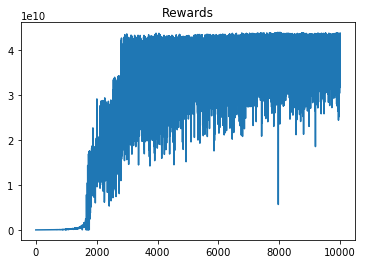

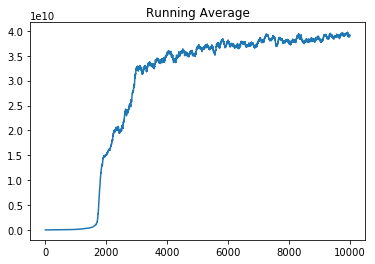

In [8]:
main()

## Approach :
  The previous implementations of KBRL are unable to converge thus we now move to a different choice of kernel and method of implementation. We decide to use the Radial Basis Function (RBF) kernel.
  
  The RBF kernel model can be thought of as a linear  model with feature extraction where the feature extractor is a RBF kernel.
  
  Mathematically the RBF kernel can be expressed as:
  $$\phi (x)=exp(-\frac{||x-c||^{2}}{\sigma^{2}})$$
  
  where:
         $x$= input vector
         $c$ = center or exemplar vector
         $\sigma$ = scale parameter.
         
  Note that $c$ is a hyper-parameter and needs to be found by experimentation.
  
  We use the RBF-sampler from scikit-learn and sample from the state space to train a linear regresor to learns its feature.
  Since we are not sure which scale parameter $\sigma$ is good we use multiple RBF kernels with different scale parameters. We also use one step of a gradient descent to integrate it with the Q learning mechanism.
  
Another implementation detail worth noting is that we only extract the features from the state $s$ and learn a different linear-model for each action.